In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

Adapted from http://kitchingroup.cheme.cmu.edu/pycse/pycse.html#sec-10-4

## Plane Poiseuille flow - BVP solve by shooting method

One approach to solving BVPs is to use the shooting method. The reason we cannot use an initial value solver for a BVP is that there is not enough information at the initial value to start. In the shooting method, we take the function value at the initial point, and guess what the function derivatives are so that we can do an integration. If our guess was good, then the solution will go through the known second boundary point. If not, we guess again, until we get the answer we need. In this example we repeat the pressure driven flow example, but illustrate the shooting method.

In the pressure driven flow of a fluid with viscosity $\mu$ between two stationary plates separated by distance $d$ and driven by a pressure drop $\Delta P/\Delta x$, the governing equations on the velocity $u$ of the fluid are (assuming flow in the x-direction with the velocity varying only in the y-direction):

$$\frac{\Delta P}{\Delta x} = \mu \frac{d^2u}{dy^2}$$

with boundary conditions $u(y=0) = 0$ and $u(y=d) = 0$, i.e. the no-slip condition at the edges of the plate.

we convert this second order BVP to a system of ODEs by letting $u_1 = u$, $u_2 = u_1'$ and then $u_2' = u_1''$. This leads to:

$\frac{d u_1}{dy} = u_2$

$\frac{d u_2}{dy} = \frac{1}{\mu}\frac{\Delta P}{\Delta x}$

with boundary conditions $u_1(y=0) = 0$ and $u_1(y=d) = 0$.

for this problem we let the plate separation be d=0.1, the viscosity $\mu = 1$, and $\frac{\Delta P}{\Delta x} = -100$.

## Shooting method
To integrate the differential equations we need starting values $u_1(0)$ and $u_2(0)$, but we only have $u_1(0)=0$. We need to guess a value for $u_2(0)$ and see if the solution goes through the $u_2(d)=0$ boundary value.



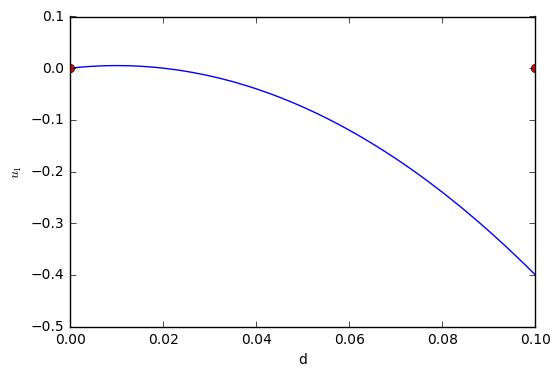

In [2]:
from scipy.integrate import odeint

d = 0.1 # plate thickness
mu = 1
Pdrop = -100

def odefun(U, y):
    u1, u2 = U
    du1dy = u2
    du2dy = 1.0 / mu * Pdrop
    return [du1dy, du2dy]

u1_0 = 0 # known
u2_0 = 1 # guessed

dspan = np.linspace(0, d)

U = odeint(odefun, [u1_0, u2_0], dspan)

def plot_results(dspan, U):
    plt.plot(dspan, U[:,0], label="Shooting method")
    plt.plot([0,d],[0,0], 'ro') # the boundary values as red circles
    plt.xlim(0,d)
    plt.xlabel('d')
    plt.ylabel('$u_1$')

plot_results(dspan, U)

Too low! Guess higher

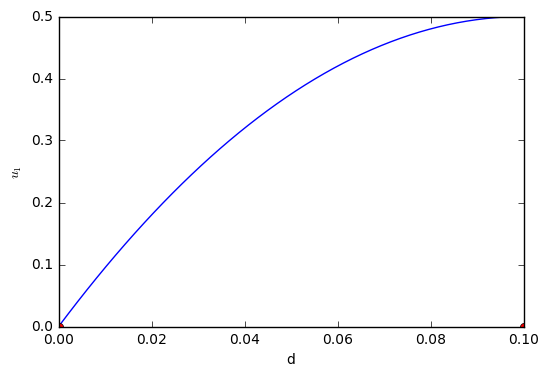

In [3]:
u1_0 = 0 # known
u2_0 = 10 # guessed higher than last time

U = odeint(odefun, [u1_0, u2_0], dspan)

plot_results(dspan, U)

Rather than keep guessing, let's use a nonlinear solver to converge upon the best value for `u2_0`

Optimized u2 is 5.000000000061994


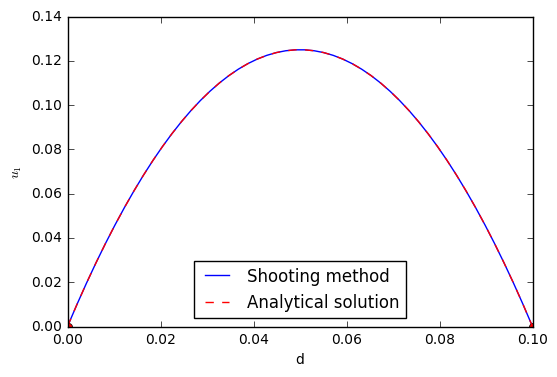

In [4]:
from scipy.optimize import fsolve

u1_0 = 0 # known

def objective(u2_0):
    U = odeint(odefun, [u1_0, u2_0], dspan)
    u1 = U[:,0]
    return u1[-1]

u2_0, = fsolve(objective, 1.0)
print("Optimized u2 is {}".format(u2_0))

# now solve with optimal u2_0
U = odeint(odefun, [u1_0, u2_0], dspan)

plot_results(dspan, U)

# Also plot an analytical solution
u = -(Pdrop) * d**2 / 2 / mu * (dspan / d - (dspan / d)**2)
plt.plot(dspan, u, 'r--', label='Analytical solution')
plt.legend(loc='best')

plt.show()

## Finite difference (second order, one dimension)
Adapted from http://kitchingroup.cheme.cmu.edu/pycse/pycse.html#sec-10-4-2 which was
adapted from http://www.physics.arizona.edu/~restrepo/475B/Notes/sourcehtml/node24.html which is a dead link.


For this example, we solve the plane poiseuille flow problem using a finite difference approach. An advantage of the approach we use here is we do not have to rewrite the second order ODE as a set of coupled first order ODEs, nor do we have to provide guesses for the solution. We do, however, have to discretize the derivatives and formulate a linear algebra problem.


> A reminder:
In the pressure driven flow of a fluid with viscosity $\mu$ between two stationary plates separated by distance $d$ and driven by a pressure drop $\Delta P/\Delta x$, the governing equations on the velocity $u$ of the fluid are (assuming flow in the x-direction with the velocity varying only in the y-direction):
$$\frac{\Delta P}{\Delta x} = \mu \frac{d^2u}{dy^2}$$
with boundary conditions $u(y=0) = 0$ and $u(y=d) = 0$, i.e. the no-slip condition at the edges of the plate.
As before we let the plate separation be $d=0.1$, the viscosity $\mu = 1$, and $\frac{\Delta P}{\Delta x} = -100$.


The idea behind the finite difference method is to approximate the derivatives by finite differences on a grid. 

Using central differences
$$\frac{d^2u}{dx^2} = \frac{1}{\mu} \frac{\Delta P}{\Delta x}$$
becomes
$$\frac{u_{i-1} - 2 u_{i} + u_{i+1}}{h^2} = \frac{1}{\mu} \frac{\Delta P}{\Delta x} = -100$$


By discretizing the ODE, we arrive at a set of linear algebra equations of the form $A y = b$, where $A$ and $b$ are defined as follows.

$$
A = \left [ \begin{array}{ccccc} %
 2         & -1  & 0                    & 0 & 0 \\
-1  & 2          & -1 & 0 & 0 \\
0                    & \ddots               & \ddots               & \ddots & 0 \\
0                    & 0                    & -1& 2 & -1  \\
0                    & 0                    & 0  & -1  & 2 \end{array} \right ] $$


$$ y = \left [ \begin{array}{c} y_i \\ \vdots \\ y_N \end{array} \right ] $$

$$ b = \left [ \begin{array}{c} 100 h^2   \\
 100 h^2 \\
\vdots \\
 100 h^2 \\
 100 h^2 \end{array} \right] 
$$




If we want to solve a **linear boundary value problem** of the **general form**: 
$$y'' = p(x)y' + q(x)y + r(x)$$
with boundary conditions $y(x_1) = \alpha$ and $y(x_2) = \beta$.
then we arrive at a set of linear algebra equations of the form $A y = b$, where $A$ and $b$ are defined as follows.

$$
A = \left [ \begin{array}{ccccc} %
 2 + h^2 q_1         & -1 + \frac{h}{2} p_1 & 0                    & 0 & 0 \\
-1 - \frac{h}{2} p_2 & 2 + h^2 q_2          & -1 + \frac{h}{2} p_2 & 0 & 0 \\
0                    & \ddots               & \ddots               & \ddots & 0 \\
0                    & 0                    & -1 - \frac{h}{2} p_{N-1} & 2 + h^2 q_{N-1} & -1 + \frac{h}{2} p_{N-1} \\
0                    & 0                    & 0  & -1 - \frac{h}{2} p_N & 2 + h^2 q_N \end{array} \right ] $$


$$ y = \left [ \begin{array}{c} y_i \\ \vdots \\ y_N \end{array} \right ] $$

$$ b = \left [ \begin{array}{c} -h^2 r_1 + ( 1 + \frac{h}{2} p_1) \alpha \\
-h^2 r_2 \\
\vdots \\
-h^2 r_{N-1} \\
-h^2 r_N + (1 - \frac{h}{2} p_N) \beta \end{array} \right] 
$$

Mapping our $u'' = \frac{1}{\mu} \frac{\Delta P}{\Delta x}$ onto the general form $$y'' = p(x)y' + q(x)y + r(x)$$ with boundary conditions $y(x_1) = \alpha$ and $y(x_2) = \beta$, we see $p(x)=0$, $q(x)=0$, $r(x)=-100$, $\alpha=0$, $\beta=0$.

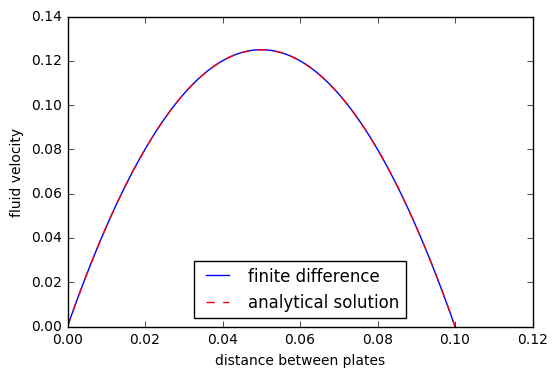

In [5]:
"""
This is set up for general p, q, r, alpha, beta
"""
# we use the notation for y'' = p(x)y' + q(x)y + r(x)
def p(x):
    return 0

def q(x):
    return 0

def r(x):
    return -100

#we use the notation y(x1) = alpha and y(x2) = beta
x1 = 0; alpha = 0.0
x2 = 0.1; beta = 0.0

npoints = 100

# compute interval width
h = (x2-x1)/npoints;

# preallocate and shape the b vector and A-matrix
b = np.zeros((npoints - 1, 1));
A = np.zeros((npoints - 1, npoints - 1));
X = np.zeros((npoints - 1, 1));

#now we populate the A-matrix and b vector elements
for i in range(npoints - 1):
    X[i,0] = x1 + (i + 1) * h

    # get the value of the BVP Odes at this x
    pi = p(X[i])
    qi = q(X[i])
    ri = r(X[i])

    if i == 0:
        # first boundary condition
        b[i] = -h**2 * ri + (1 + h / 2 * pi)*alpha;
    elif i == npoints - 1:
        # second boundary condition
        b[i] = -h**2 * ri + (1 - h / 2 * pi)*beta;
    else:
        b[i] = -h**2 * ri # intermediate points

    for j in range(npoints - 1):
        if j == i: # the diagonal
            A[i,j] = 2 + h**2 * qi
        elif j == i - 1: # left of the diagonal
            A[i,j] = -1 - h / 2 * pi
        elif j == i + 1: # right of the diagonal
            A[i,j] = -1 + h / 2 * pi
        else:
            A[i,j] = 0 # off the tri-diagonal

# solve the equations A*y = b for Y
Y = np.linalg.solve(A,b)

x = np.hstack([x1, X[:,0], x2])
y = np.hstack([alpha, Y[:,0], beta])

plt.plot(x, y, label='finite difference')

mu = 1
d = 0.1
x = np.linspace(0,0.1);
Pdrop = -100 # this is DeltaP/Deltax
u = -(Pdrop) * d**2 / 2.0 / mu * (x / d - (x / d)**2)
plt.plot(x,u,'r--', label='analytical solution')

plt.xlabel('distance between plates')
plt.ylabel('fluid velocity')
plt.legend(loc='best')

## Boundary conditions
This example had a *Dirichlet boundary condition* (fixed value). What if you had a *Neumann boundary condition* (fixed derivative)??
An example is solving for temperature $T(x)$ you may specify thermal insulation ($dT/dx=0$) at one boundary instead of a fixed temperature.

# PDEs - method of lines

Adapted from http://kitchingroup.cheme.cmu.edu/pycse/pycse.html#sec-10-5-1

The PDE that describes the transient behavior of a plug flow reactor with constant volumetric flow rate is:
$$ \frac{\partial C_A}{\partial t} = -v_0 \frac{\partial C_A}{\partial V} + r_A $$

To solve this numerically in python, we will utilize the method of lines. The idea is to discretize the reactor in volume, and approximate the spatial derivatives by finite differences. Then we will have a set of coupled ordinary differential equations that can be solved in the usual way. Let us simplify the notation with $C = C_A$, and let $r_A = -k C^2$. Graphically this looks like this:

![pde-method-of-lines](http://kitchingroup.cheme.cmu.edu/pycse/images/pde-method-of-lines.png)

This leads to the following set of equations:

\begin{eqnarray}
\frac{dC_0}{dt} &=& 0 \text{ (entrance concentration never changes)} \\
\frac{dC_1}{dt} &=& -v_0 \frac{C_1 - C_0}{V_1 - V_0} - k C_1^2 \\
\frac{dC_2}{dt} &=& -v_0 \frac{C_2 - C_1}{V_2 - V_1} - k C_2^2 \\
\vdots \\
\frac{dC_4}{dt} &=& -v_0 \frac{C_4 - C_3}{V_4 - V_3} - k C_4^2
\end{eqnarray}

Last, we need initial conditions for all the nodes in the discretization. Let us assume the reactor was full of empty solvent, so that $C_i = 0$ at $t=0$. In the next block of code, we get the transient solutions, and the steady state solution.

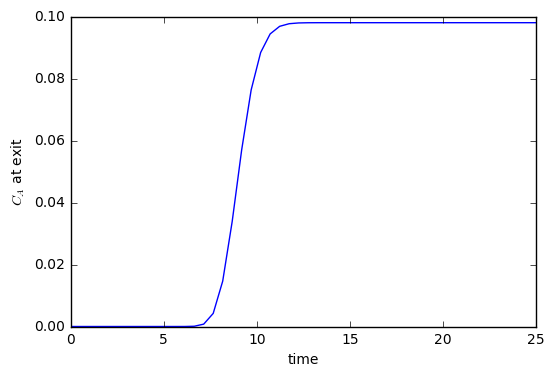

In [6]:
from scipy.integrate import odeint

Ca0 = 2     # Entering concentration
vo = 2      # volumetric flow rate
volume = 20 # total volume of reactor, spacetime = 10
k = 1       # reaction rate constant

N = 100     # number of points to discretize the reactor volume on

init = np.zeros(N)    # Concentration in reactor at t = 0
init[0] = Ca0         # concentration at entrance

V = np.linspace(0, volume, N) # discretized volume elements
tspan = np.linspace(0, 25)    # time span to integrate over

def method_of_lines(C, t):
    'coupled ODES at each node point'
    D = np.zeros_like(C) # C0 is constant at entrance, so D[0] = 0
    D[1:] = -vo * np.diff(C) / np.diff(V) - k * C[1:]**2
    return D
sol = odeint(method_of_lines, init, tspan)

plt.plot(tspan, sol[:, -1])
plt.xlabel('time')
plt.ylabel('$C_A$ at exit')
plt.show()

After approximately one space time, the steady state solution is reached at the exit. For completeness, we also examine the steady state solution.

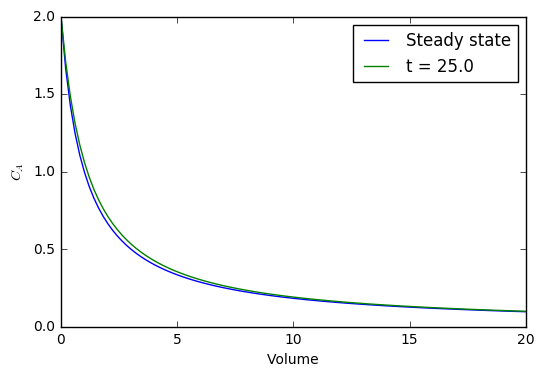

In [7]:
# steady state solution
def pfr(C, V):
    return 1.0 / vo * (-k * C**2)
ssol = odeint(pfr, Ca0, V)
plt.plot(V, ssol, label='Steady state')
plt.plot(V, sol[-1], label='t = {}'.format(tspan[-1]))
plt.xlabel('Volume')
plt.ylabel('$C_A$')
plt.legend(loc='best')
plt.show()

There is some minor disagreement between the final transient solution and the steady state solution. That is due to the approximation in discretizing the reactor volume. In this example we used 100 nodes. You get better agreement with a larger number of nodes, say 200 or more. Of course, it takes slightly longer to compute then, since the number of coupled odes is equal to the number of nodes.



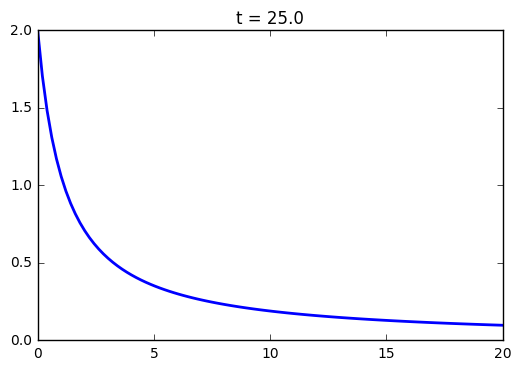

In [12]:
"""
Note that you will need to install ffmpeg or mencoder. Simplest way is probably:
    conda install -c rmg ffmpeg
"""
from matplotlib import animation
import matplotlib
matplotlib.rc('animation', html='html5')
# make empty figure
fig = plt.figure()
ax = plt.axes(xlim=(0, 20), ylim=(0, 2))
line, = ax.plot(V, init, lw=2)

def animate(i):
    line.set_xdata(V)
    line.set_ydata(sol[i])
    ax.set_title('t = {0:.1f}'.format(tspan[i]))
    ax.figure.canvas.draw()
    return line,

anim = animation.FuncAnimation(fig, animate, frames=50,  blit=True)
anim